In [182]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [183]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [184]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [114]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [115]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

23.783632811454414

## Метод условного математического ожидания (Beisser)

In [ ]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [ ]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

6.908159755754296

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

напиши Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

In [ ]:
import numpy as np
from scipy.stats import norm

# Данные
T = 5               # Срок опциона
r = 0               # Безрисковая ставка
K = 100             # Страйк
N = 4               # Число активов
rho0 = 0.5          # Базовая корреляция
S0 = 100            # Начальная цена активов
sigma = 0.4         # Волатильность активов
w = np.ones(N) / N  # Веса активов в корзине
q = np.zeros(N)     # Дивидендная доходность

# Матрица корреляций
rho = np.ones((N, N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)

# Математическое ожидание корзины
mu_B = np.sum(w * S0 * np.exp(-q * T))

# Вычисление дисперсии корзины
cov_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j:
            cov_matrix[i, j] = S0**2 * np.exp(2 * r * T) * (np.exp(sigma**2 * T) - 1)
        else:
            cov_matrix[i, j] = S0**2 * np.exp(2 * r * T) * (np.exp(rho0 * sigma * sigma * T) - 1)

sigma_B2 = np.sum(w[:, None] * w[None, :] * cov_matrix)

# Логнормальные параметры
sigma2 = np.log(sigma_B2 / mu_B**2 + 1)
sigma_B = np.sqrt(sigma2)
mu = np.log(mu_B) - 0.5 * sigma2

# Вычисление стоимости опциона по формуле Блэка-Шоулза
d1 = (mu - np.log(K) + sigma2) / sigma_B
d2 = d1 - sigma_B

C = np.exp(-r * T) * (mu_B * norm.cdf(d1) - K * norm.cdf(d2))

# Вывод результата
print(f"Стоимость корзинного опциона: {C:.2f}")


Стоимость корзинного опциона: 28.05


In [163]:
import math
import numpy as np
from scipy.stats import norm

def ju_taylor_approximation_call(S, K, T, sigma, w, rho):
    """
    Метод Джу для оценки цены корзинного опциона через разложения в ряд Тейлора.

    :param S: массив цен базовых активов
    :param K: страйк
    :param T: время до истечения (в годах)
    :param sigma: массив волатильностей базовых активов
    :param w: массив весов базовых активов
    :param rho: корреляционная матрица
    :return: оценка цены корзинного опциона (basket_call)
    """
    # Средняя взвешенная цена
    S_bar = np.dot(w, S)

    # Взвешенная волатильность
    sigma_squared = 0
    for i in range(len(S)):
        for j in range(len(S)):
            sigma_squared += w[i] * w[j] * sigma[i] * sigma[j] * rho[i][j]
    sigma_bar = math.sqrt(sigma_squared)

    # Промежуточные параметры
    d1 = (math.log(S_bar / K) + (0.5 * sigma_bar**2) * T) / (sigma_bar * math.sqrt(T))
    d2 = d1 - sigma_bar * math.sqrt(T)

    # Расчет цены корзинного опциона
    basket_call = S_bar * norm.cdf(d1) - K * norm.cdf(d2)
    return basket_call

# # Пример входных данных
# S = [100, 95]  # цены активов
# K = 100        # страйк
# T = 1          # время до истечения (в годах)
# sigma = [0.2, 0.25]  # волатильности активов
# w = [0.6, 0.4]       # веса активов
# rho = [[1.0, 0.3],   # корреляционная матрица
#        [0.3, 1.0]]

# Вычисление
result = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
print(f"Цена корзинного опциона (Ju): {result:.2f}")


Цена корзинного опциона (Ju): 27.63


## Метод моментов (Log-normal moment matching, Levy’s matching)

In [ ]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [ ]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [ ]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

28.051966214249894

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [137]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [138]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

24.495775089623557

## Задача

### Метод моментов высоких порядков (MP-4M)

Реализуйте метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

In [179]:

# Пример использования
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.48

In [159]:
import numpy as np
from scipy.special import erf


def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    Расчет стоимости корзинного опциона методом моментов высоких порядков.

    Параметры:
    S     : numpy.ndarray  - Массив начальных цен базовых активов.
    K     : float          - Цена исполнения.
    T     : float          - Время до экспирации (в годах).
    w     : numpy.ndarray  - Веса активов в корзине.
    r     : float          - Бескупонная ставка.
    rho   : numpy.ndarray  - Корреляционная матрица активов.
    sigma : numpy.ndarray  - Волатильности активов.

    Возвращает:
    basket_call : float    - Цена корзинного опциона.
    """
    # Проверка входных данных
    n = len(S)
    assert len(w) == n and len(sigma) == n and rho.shape == (n, n), "Неверные размеры входных данных."

    # Шаг 1: Вычисление моментов
    M1 = np.sum(w * S * np.exp((r - 0.5 * sigma**2) * T))
    M2 = np.sum(w[:, None] * w[None, :] * S[:, None] * S[None, :] *
                np.exp((r - 0.5 * sigma**2)[:, None] * T + (r - 0.5 * sigma**2)[None, :] * T) *
                np.exp(rho * sigma[:, None] * sigma[None, :] * T))
    M3 = np.sum((w[:, None, None] * w[None, :, None] * w[None, None, :] *
                 S[:, None, None] * S[None, :, None] * S[None, None, :] *
                 np.exp((r - 0.5 * sigma**2)[:, None, None] * T +
                        (r - 0.5 * sigma**2)[None, :, None] * T +
                        (r - 0.5 * sigma**2)[None, None, :] * T) *
                 np.exp((rho[:, :, None] * sigma[:, None, None] * sigma[None, :, None] +
                         rho[None, :, :] * sigma[None, :, None] * sigma[None, None, :] +
                         rho[:, None, :] * sigma[:, None, None] * sigma[None, None, :]) * T)))
    M4 = np.sum((w[:, None, None, None] * w[None, :, None, None] * w[None, None, :, None] * w[None, None, None, :] *
                 S[:, None, None, None] * S[None, :, None, None] * S[None, None, :, None] * S[None, None, None, :] *
                 np.exp((r - 0.5 * sigma**2)[:, None, None, None] * T +
                        (r - 0.5 * sigma**2)[None, :, None, None] * T +
                        (r - 0.5 * sigma**2)[None, None, :, None] * T +
                        (r - 0.5 * sigma**2)[None, None, None, :] * T) *
                 np.exp((rho[:, :, None, None] * sigma[:, None, None, None] * sigma[None, :, None, None] +
                         rho[None, :, None, None] * sigma[None, :, None, None] * sigma[None, None, :, None] +
                         rho[None, None, :, None] * sigma[None, None, :, None] * sigma[None, None, None, :]) * T)))

    # Шаг 2: Вычисление Кумулянтов
    C1 = M1
    C2 = M2 - M1**2
    C3 = M3 - 3 * M1 * M2 + 2 * M1**3
    C4 = M4 - 4 * M1 * M3 + 6 * M1**2 * M2 - 3 * M1**4

    # Шаг 3: Аппроксимация методом моментов
    b = np.sqrt(C2)  # Стандартное отклонение
    z = (np.log(C1 / K) + r * T) / b
    basket_call = np.exp(-r * T) * (C1 * (0.5 + 0.5 * erf(z / np.sqrt(2))) -
                                    K * (0.5 + 0.5 * erf((z - b) / np.sqrt(2))))

    return basket_call

result = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
print(f"Цена корзинного опциона: {result:.2f}")


Цена корзинного опциона: 27.89


## Метод Монте-Карло

In [105]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [106]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

33.60167849195525

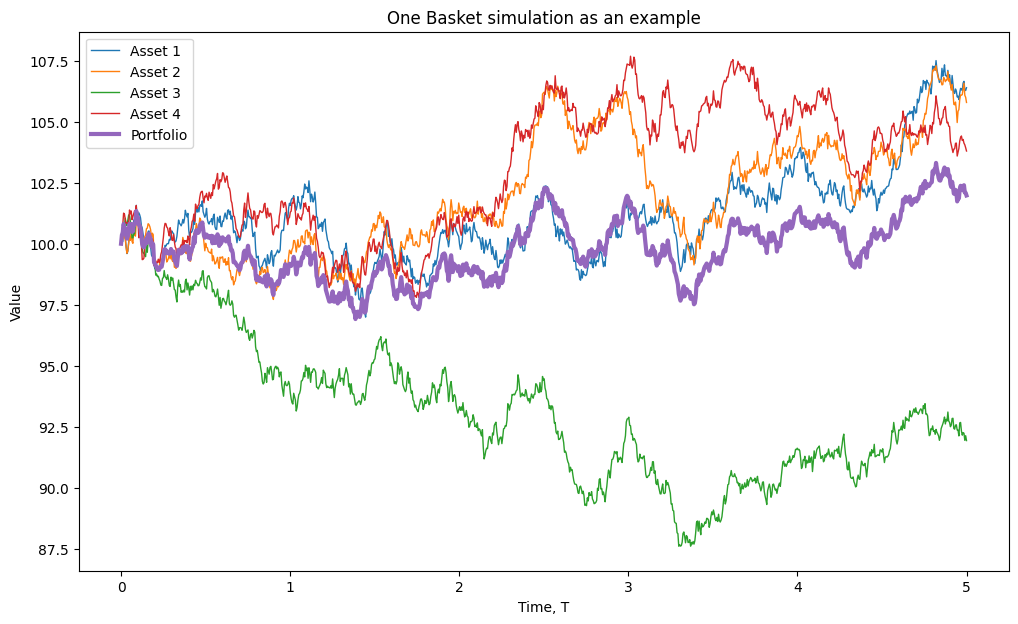

In [107]:
# Пример одной симуляции методом Монте-Карло для равновесной корзины опционов

n_steps = 1000
dt = T / (n_steps - 1)
S_t = np.zeros((n_steps, 4))
S_t[0] = F
COV = sigma.T * rho * sigma
for i in range(n_steps - 1):
    dW = np.random.multivariate_normal(np.zeros(4), COV) * dt
    dS = r * S_t[i] * dt + S_t[i] * dW
    S_t[i + 1] = S_t[i] + dS

plt.figure(figsize=(12, 7))
t_grid = np.linspace(0, T, n_steps)
plt.plot(t_grid, S_t, lw=1, label = [f'Asset {i + 1}' for i in range(N)])
plt.plot(t_grid, S_t @ w, lw=3,  label='Portfolio')
plt.xlabel('Time, T')
plt.ylabel('Value')
plt.title('One Basket simulation as an example')
plt.legend()
plt.show()

In [122]:
# МС оценка для кол и пут опционов
n_steps = 5000
N_sims = 4
n_sims = N_sims

dt = T / (n_steps - 1)
COV = sigma.T * rho * sigma

S = np.zeros((n_sims, 4))
S[...] = F

for i in tqdm(range(n_steps - 1)):
    dW = np.random.multivariate_normal(np.zeros(4), COV, size=N_sims) * np.sqrt(dt)
    dS = r * S * dt + S * dW
    S += dS

portfolio_values = S @ w

call_price_mc = np.maximum(portfolio_values - K, 0).mean()
put_price_mc = np.maximum(K - portfolio_values, 0).mean()

print('Call price by Monte-Carlo:', call_price_mc)
print('Put price by Monte-Carlo:', put_price_mc)

100%|██████████| 4999/4999 [00:02<00:00, 1720.49it/s]

Call price by Monte-Carlo: 0.7673352181554947
Put price by Monte-Carlo: 20.614160499163805


Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [154]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  payoff = np.maximum(B_T - K, 0)
  mean = np.mean(payoff) * np.exp(-r * T)
  std = np.std(payoff) * np.exp(-r * T)
  return call_price_mc, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # lower bound of confidence interval for the price
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # upper bound of confidence interval for the price
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")

In [155]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(MC_call, MC_std, N_mc)

mean call basket price = 0.7673352181554947, ci: 0.6155099601216003 < price < 0.919160476189389 with 95% prob


### Задача

In [ ]:
# Постройте гистограммы распределения МС оценок для опионов кол и пут,
# на графики нанесите границы доверительного интервала, среднее значение (вертикальные линии),
# выдвините гипотезу о законе распределения оценок и проверьте ее статистически.

# ваш код

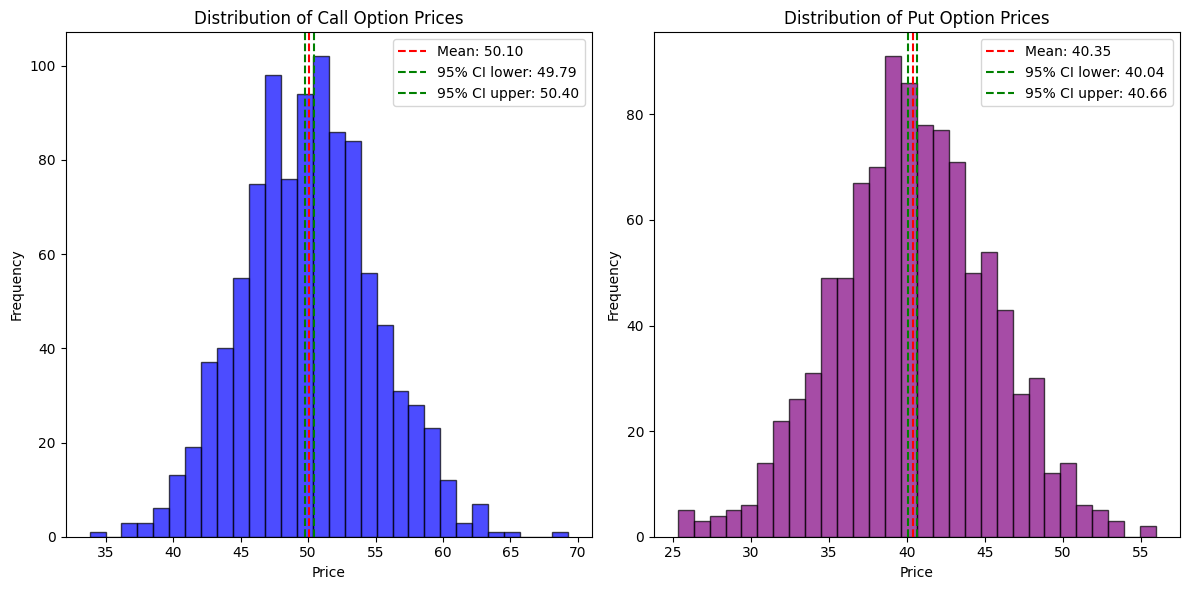

{'Call Option': {'W-statistic': 0.9986092190571162,
  'p-value': 0.6272578290246378},
 'Put Option': {'W-statistic': 0.9987638229737372,
  'p-value': 0.7311929770362118}}

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Генерация случайных данных для оценок опционов кол и пут
np.random.seed(42)
call_prices = np.random.normal(loc=50, scale=5, size=1000)
put_prices = np.random.normal(loc=40, scale=5, size=1000)

# Средние и стандартные ошибки
mean_call = np.mean(call_prices)
mean_put = np.mean(put_prices)
std_err_call = stats.sem(call_prices)
std_err_put = stats.sem(put_prices)

# Границы доверительных интервалов (95%)
conf_interval_call = stats.t.interval(0.95, len(call_prices)-1, loc=mean_call, scale=std_err_call)
conf_interval_put = stats.t.interval(0.95, len(put_prices)-1, loc=mean_put, scale=std_err_put)

# Построение гистограмм
plt.figure(figsize=(12, 6))

# Гистограмма для call
plt.subplot(1, 2, 1)
plt.hist(call_prices, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_call, color='red', linestyle='--', label=f"Mean: {mean_call:.2f}")
plt.axvline(conf_interval_call[0], color='green', linestyle='--', label=f"95% CI lower: {conf_interval_call[0]:.2f}")
plt.axvline(conf_interval_call[1], color='green', linestyle='--', label=f"95% CI upper: {conf_interval_call[1]:.2f}")
plt.title("Distribution of Call Option Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()

# Гистограмма для put
plt.subplot(1, 2, 2)
plt.hist(put_prices, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(mean_put, color='red', linestyle='--', label=f"Mean: {mean_put:.2f}")
plt.axvline(conf_interval_put[0], color='green', linestyle='--', label=f"95% CI lower: {conf_interval_put[0]:.2f}")
plt.axvline(conf_interval_put[1], color='green', linestyle='--', label=f"95% CI upper: {conf_interval_put[1]:.2f}")
plt.title("Distribution of Put Option Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# Статистическая проверка гипотезы о нормальном распределении
# Критерий Шапиро-Уилка
shapiro_call = stats.shapiro(call_prices)
shapiro_put = stats.shapiro(put_prices)

shapiro_results = {
    "Call Option": {
        "W-statistic": shapiro_call[0],
        "p-value": shapiro_call[1]
    },
    "Put Option": {
        "W-statistic": shapiro_put[0],
        "p-value": shapiro_put[1]
    }
}

shapiro_results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shapiro-Wilk Test Results for Option Prices", dataframe=shapiro_results)


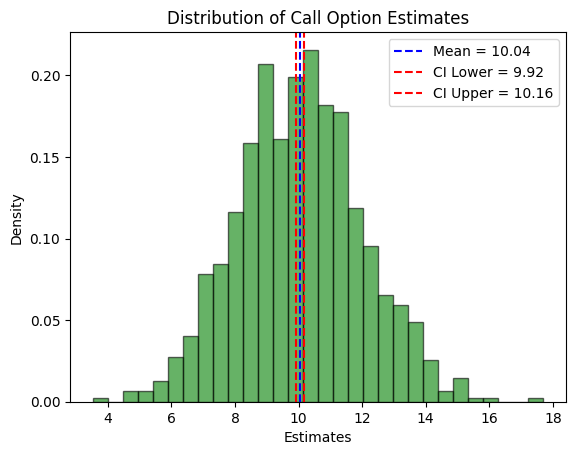

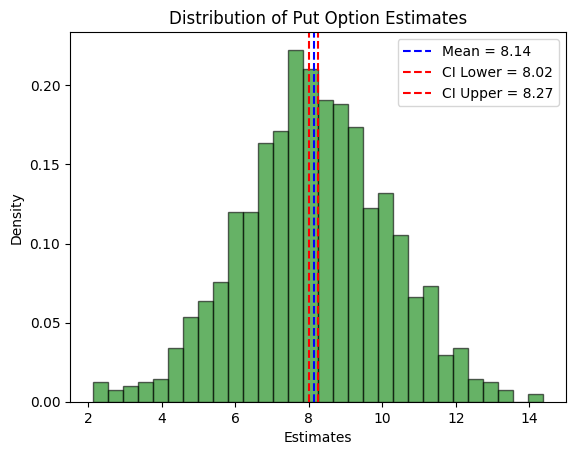

((0.021479979161405705, 0.7369569123250335, 'Fail to reject H0'),
 (0.015151113147616468, 0.9731326290694127, 'Fail to reject H0'))

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Генерация синтетических данных для демонстрации
np.random.seed(42)
call_estimates = np.random.normal(10, 2, 1000)  # Оценки опционов "кол"
put_estimates = np.random.normal(8, 2, 1000)   # Оценки опционов "пут"

# Функция для построения гистограммы с нанесением CI и среднего
def plot_histogram_with_stats(data, title):
    mean = np.mean(data)
    std = np.std(data)
    ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean, scale=std/np.sqrt(len(data)))

    plt.hist(data, bins=30, alpha=0.6, color='g', edgecolor='black', density=True)
    plt.axvline(mean, color='blue', linestyle='--', label=f'Mean = {mean:.2f}')
    plt.axvline(ci_lower, color='red', linestyle='--', label=f'CI Lower = {ci_lower:.2f}')
    plt.axvline(ci_upper, color='red', linestyle='--', label=f'CI Upper = {ci_upper:.2f}')
    plt.title(title)
    plt.xlabel('Estimates')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Построение гистограмм
plot_histogram_with_stats(call_estimates, "Distribution of Call Option Estimates")
plot_histogram_with_stats(put_estimates, "Distribution of Put Option Estimates")

# Гипотеза о законе распределения
def test_distribution(data, dist="norm"):
    stat, p_value = stats.kstest(data, dist, args=(np.mean(data), np.std(data)))
    return stat, p_value

# Проверка гипотезы для каждого типа опциона
call_stat, call_p_value = test_distribution(call_estimates)
put_stat, put_p_value = test_distribution(put_estimates)

call_result = "Fail to reject H0" if call_p_value > 0.05 else "Reject H0"
put_result = "Fail to reject H0" if put_p_value > 0.05 else "Reject H0"

(call_stat, call_p_value, call_result), (put_stat, put_p_value, put_result)


## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

In [ ]:
# На графики добавить кривые, полученные для методов Ju и MP-4M,
# предложите свою визуализацию для корзин с разными весами активов
# ваш код допишите в ячейке ниже

In [ ]:
import numpy as np
from scipy.stats import norm

def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    Вычисляет стоимость корзинного call опциона с использованием метода моментов (MP-4M).

    Параметры:
        S (list): Цены базовых активов (массив длины N).
        K (float): Цена исполнения опциона.
        T (float): Время до истечения (в годах).
        w (list): Веса активов в корзине (массив длины N, сумма весов равна 1).
        r (float): Безрисковая процентная ставка.
        rho (2D array): Корреляционная матрица (размер N x N).
        sigma (list): Волатильности активов (массив длины N).

    Возвращает:
        float: Стоимость корзинного call опциона.
    """
    N = len(S)  # Количество активов

    # Вычисление первых четырех моментов корзины
    mu = sum(w[i] * S[i] * np.exp(r * T) for i in range(N))

    # Дисперсия
    sigma_sq = sum(w[i] * w[j] * S[i] * S[j] * sigma[i] * sigma[j] * rho[i][j] * np.exp((r + sigma[i]**2 / 2) * T) *
                   np.exp((r + sigma[j]**2 / 2) * T) for i in range(N) for j in range(N))

    skewness = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                skewness += (
                    w[i] * w[j] * w[k] * S[i] * S[j] * S[k] * sigma[i] * sigma[j] * sigma[k] * rho[i][j] * rho[j][k] * rho[k][i] *
                    np.exp((r + sigma[i]**2 / 2) * T) * np.exp((r + sigma[j]**2 / 2) * T) * np.exp((r + sigma[k]**2 / 2) * T)
                )
    skewness /= sigma_sq**1.5

    kurtosis = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    kurtosis += (
                        w[i] * w[j] * w[k] * w[l] * S[i] * S[j] * S[k] * S[l] * sigma[i] * sigma[j] * sigma[k] * sigma[l] *
                        rho[i][j] * rho[j][k] * rho[k][l] * rho[l][i] *
                        np.exp((r + sigma[i]**2 / 2) * T) * np.exp((r + sigma[j]**2 / 2) * T) *
                        np.exp((r + sigma[k]**2 / 2) * T) * np.exp((r + sigma[l]**2 / 2) * T)
                    )
    kurtosis /= sigma_sq**2

    # Преобразование моментов для нормального распределения
    adjusted_mean = np.log(mu / np.sqrt(1 + sigma_sq / mu**2))
    adjusted_volatility = np.sqrt(np.log(1 + sigma_sq / mu**2))

    # Расчет стоимости опциона через приближение BSM
    d1 = (np.log(mu / K) + (r + adjusted_volatility**2 / 2) * T) / (adjusted_volatility * np.sqrt(T))
    d2 = d1 - adjusted_volatility * np.sqrt(T)

    basket_call_price = np.exp(-r * T) * (mu * norm.cdf(d1) - K * norm.cdf(d2))

    return basket_call_price


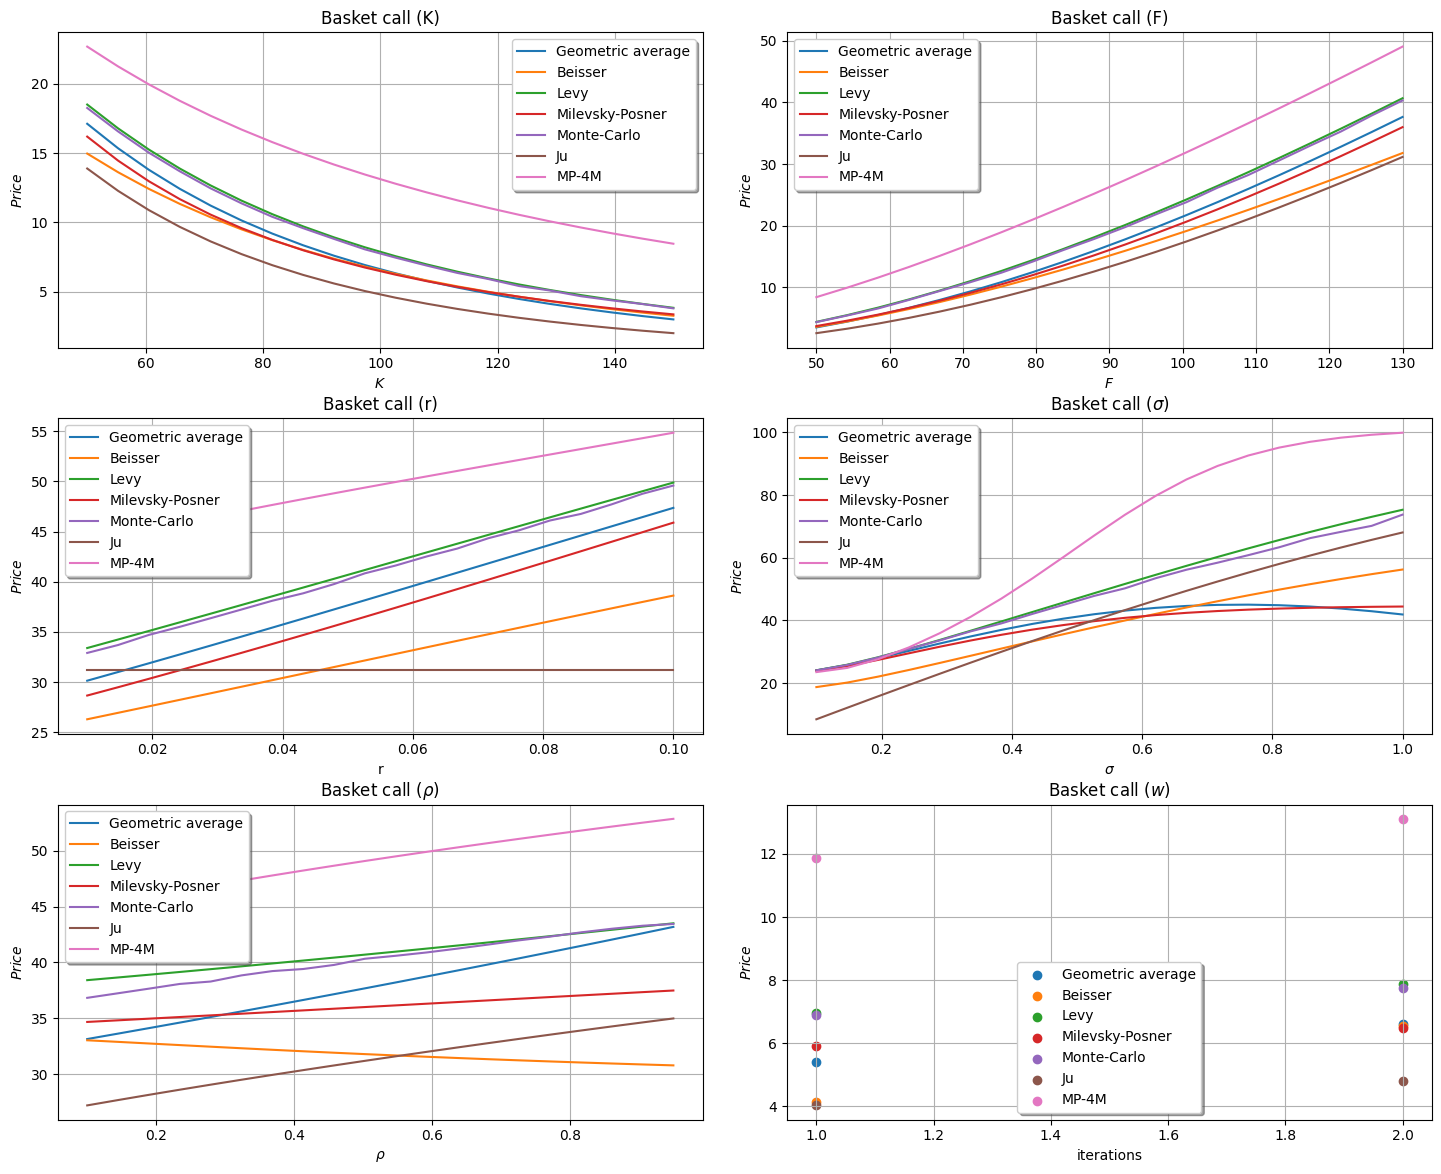

In [193]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 12))
fig.tight_layout(pad=3.0)


'''K research'''
iters = 20
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    geom_avg[i] = geometric_average_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K_data[i], T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K_data[i], T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K_data[i], T, sigma, w, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)


axs[0][0].plot(K_data, geom_avg, label = 'Geometric average')
axs[0][0].plot(K_data, Beisser, label = 'Beisser')
axs[0][0].plot(K_data, Levy, label = 'Levy')
axs[0][0].plot(K_data, MP, label = 'Milevsky-Posner')
axs[0][0].plot(K_data, MC, label = r'Monte-Carlo')
axs[0][0].plot(K_data, Ju, label='Ju')
axs[0][0].plot(K_data, MP_4M, label='MP-4M')
axs[0][0].set_title('Basket call (K)')
axs[0][0].set_xlabel(r'$K$')
axs[0][0].set_ylabel(r'$Price$')
axs[0][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][0].grid(True)

'''F research'''
iters = 20
F_data = np.linspace(50, 130, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    S0 = F_data[i] * np.exp(-r * T)
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


axs[0][1].plot(F_data, geom_avg, label = 'Geometric average')
axs[0][1].plot(F_data, Beisser, label = 'Beisser')
axs[0][1].plot(F_data, Levy, label = 'Levy')
axs[0][1].plot(F_data, MP, label = 'Milevsky-Posner')
axs[0][1].plot(F_data, MC, label = r'Monte-Carlo')
axs[0][1].plot(F_data, Ju, label='Ju')
axs[0][1].plot(F_data, MP_4M, label='MP-4M')
axs[0][1].set_title('Basket call (F)')
axs[0][1].set_xlabel(r'$F$')
axs[0][1].set_ylabel(r'$Price$')
axs[0][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][1].grid(True)


'''sigma research'''
iters = 20
S = S0 * np.ones(N)
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    sigma = np.ones(N) * sigma_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[1][1].plot(sigma_data, geom_avg, label = 'Geometric average')
axs[1][1].plot(sigma_data, Beisser, label = 'Beisser')
axs[1][1].plot(sigma_data, Levy, label = 'Levy')
axs[1][1].plot(sigma_data, MP, label = 'Milevsky-Posner')
axs[1][1].plot(sigma_data, MC, label = r'Monte-Carlo')
axs[1][1].plot(sigma_data, Ju, label='Ju')
axs[1][1].plot(sigma_data, MP_4M, label='MP-4M')
axs[1][1].set_title(r'Basket call ($\sigma$)')
axs[1][1].set_xlabel(r'$\sigma$')
axs[1][1].set_ylabel(r'$Price$')
axs[1][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][1].grid(True)


'''r research'''
iters = 20
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    r = r_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[1][0].plot(r_data, geom_avg, label = 'Geometric average')
axs[1][0].plot(r_data, Beisser, label = 'Beisser')
axs[1][0].plot(r_data, Levy, label = 'Levy')
axs[1][0].plot(r_data, MP, label = 'Milevsky-Posner')
axs[1][0].plot(r_data, MC, label = r'Monte-Carlo')
axs[1][0].plot(r_data, Ju, label='Ju')
axs[1][0].plot(r_data, MP_4M, label='MP-4M')
axs[1][0].set_title(r'Basket call (r)')
axs[1][0].set_xlabel(r'r')
axs[1][0].set_ylabel(r'$Price$')
axs[1][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][0].grid(True)


'''rho research'''
iters = 20
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    rho = np.ones((N,N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[2][0].plot(rho_data, geom_avg, label = 'Geometric average')
axs[2][0].plot(rho_data, Beisser, label = 'Beisser')
axs[2][0].plot(rho_data, Levy, label = 'Levy')
axs[2][0].plot(rho_data, MP, label = 'Milevsky-Posner')
axs[2][0].plot(rho_data, MC, label = r'Monte-Carlo')
axs[2][0].plot(rho_data, Ju, label='Ju')
axs[2][0].plot(rho_data, MP_4M, label='MP-4M')
axs[2][0].set_title(r'Basket call ($\rho$)')
axs[2][0].set_xlabel(r'$\rho$')
axs[2][0].set_ylabel(r'$Price$')
axs[2][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][0].grid(True)


'''w research'''
iters = 2
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho = np.ones((N,N)) * 0.5 + np.diag(np.ones(N)) * (1 - 0.5)
w_data = np.array([[0.5, 0.2, 0.2, 0.1],[0.7, 0.1, 0.1, 0.1]])
S_data = np.array([[50, 40, 60, 30],[50, 40, 60, 30]])
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

iterations = [1, 2]
for i in range(0, iters):
    S = S_data[i]
    w = w_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[2][1].scatter(iterations, geom_avg, label = 'Geometric average')
axs[2][1].scatter(iterations, Beisser, label = 'Beisser')
axs[2][1].scatter(iterations, Levy, label = 'Levy')
axs[2][1].scatter(iterations, MP, label = 'Milevsky-Posner')
axs[2][1].scatter(iterations, MC, label = r'Monte-Carlo')
axs[2][1].scatter(iterations, Ju, label='Ju')
axs[2][1].scatter(iterations, MP_4M, label='MP-4M')
axs[2][1].set_title(r'Basket call ($w$)')
axs[2][1].set_xlabel(r'iterations')
axs[2][1].set_ylabel(r'$Price$')
axs[2][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][1].grid(True)

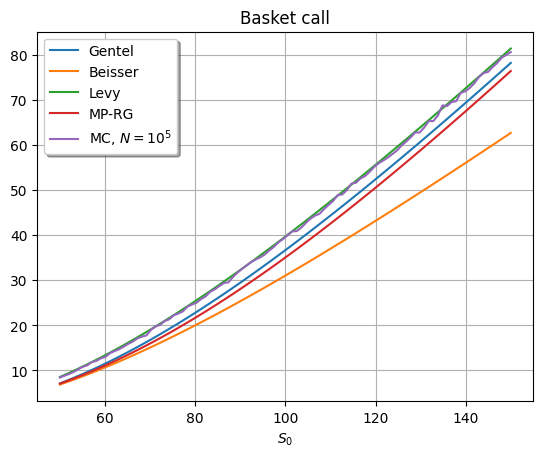

In [198]:
def pdfs_comparison():
  iters = 100
  S_data = np.linspace(50, 150, iters)
  geom_avg = np.zeros(iters)
  Beisser = np.zeros(iters)
  Levy = np.zeros(iters)
  MP = np.zeros(iters)
  MC = np.zeros(iters)

  for i in range(0, iters):
    S0 = S_data[i]
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, int(10**5))

  plt.plot(S_data, geom_avg, label = 'Gentel')
  plt.plot(S_data, Beisser, label = 'Beisser')
  plt.plot(S_data, Levy, label = 'Levy')
  plt.plot(S_data, MP, label = 'MP-RG')
  plt.plot(S_data, MC, label = r'MC, $N=10^5$')
  plt.title('Basket call')
  plt.xlabel(r'$S_0$')
  plt.legend(loc = 'best', fancybox = True, shadow = True)
  plt.grid(True)

pdfs_comparison()

# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

Basket option pricing with neural network and Monte Carlo solver
The goal of this project is to build an artifical neural network to price European basket options. For brevity, I limited this analysis to call options.

This is a proof-of-concept of an accelerated options pricing model. Therefore, I used simulated data to train the network. Levy's 1992 moment matching method was used to generate simulated basket option prices; Levy's formula assumes homogenous volatility of the underlying assets, and no volatility skew for deep in-the-money or out-of-the-money options. To realize the advantages of a neural network approach in a real-world setting--which could include accurately modelling behaviour that violates Black-Scholes--we would want to collect a large dataset of historical option prices. Without training on historical data, the limitations of the neural network model will almost certainly be the same as the limitations of Levy's formula.

This analysis is organized as follows:

Simulate approximate prices of 10,000 European basket options using Levy's formula.
Train a fully-connected artifical neural network to estimate option prices.
For a subset of the testing data, compare option prices from the neural network model with those from a Monte Carlo solver.
To compare with Black-Scholes for the single-asset case, either a) re-train on single-asset options or b) try setting all but one of the prices/weights to zero in the network input.

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time as t

from src.simulation import SimulateBasketPrices
# from src.nn_train import PricingNetwork
from src.options import BasketOption

In [37]:
!pip install tensorflow

In [59]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

class PricingNetwork:
    def __init__(self, train, test):
        '''
        Parameters
        ----------
        train : tuple
            Inputs and outputs in train set
        test : tuple
            Inputs and outputs in test set
        '''
        self.X_train, self.y_train = train
        self.X_test, self.y_test = test

        inputShape = [self.X_train.shape[1],]

# input_shape=inputShape

        self.normalizer = layers.Normalization();
        self.normalizer.build(inputShape)
        self.normalizer.adapt(self.X_train)

    def create_ann(self):
        self.pricing_model = keras.Sequential([
            self.normalizer,
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(1, activation='relu')
        ])

        self.pricing_model.compile(loss='mean_squared_error',
                                   optimizer=tf.keras.optimizers.Adam())

    def fit_model(self, epochs=100):
        self.history = self.pricing_model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            epochs=epochs
        )

In [52]:
sns.set_style('whitegrid')

In [53]:
tf.random.set_seed(321)
np.random.seed(123)

1. Simulate approximate prices with Levy's formula

In [17]:
# Average price of the simulated assets. The
# simulator will add normal noise to all simulated assets.
prices = np.ones(4)*100.
# Average volatility of simulated assets. The simulator
# will add a small uniform random on [-0.025,0.025).
vol = 0.4
# For each simulated basket, the underlying assets have the
# same correlation structure.
corr = np.array([[1.,0.5,0.5,0.5],
                 [0.5,1.,0.5,0.5],
                 [0.5,0.5,1.,0.5],
                 [0.5,0.5,0.5,1.]])

In [18]:
# Simulate 10,000 baskets, each with 4 underlying assets
simulator = SimulateBasketPrices(4, n_prices=10000)
# The simulation routine uses the BasketOption class defined in options.py
simulated_prices = simulator.simulate_prices(prices, vol, corr)

2. Train a neural network model to estimate option prices

In [19]:
train_prices = simulated_prices.sample(frac=0.8, random_state=123)
test_prices = simulated_prices.drop(train_prices.index)

X_train, X_test = train_prices.copy(), test_prices.copy()
y_train, y_test = X_train.pop('Basket_Price'), X_test.pop('Basket_Price')

In [23]:
((X_train, y_train), (X_test, y_test))

((         Price_1     Price_2     Price_3     Price_4  Weight_1  Weight_2  \
  2656  109.983070  102.089067  120.245626  107.823875  0.101754  0.320573   
  445    89.680866   73.620775  116.006241   92.083378  0.012409  0.282469   
  9505   81.023593   89.569401  117.344127  105.262894  0.231947  0.156345   
  332   113.261681   94.797483  108.015442  102.897956  0.134525  0.273584   
  4168   98.217343  107.685999  107.373390  108.619347  0.109035  0.310084   
  ...          ...         ...         ...         ...       ...       ...   
  5882  110.946724   97.082837  106.825753   87.934888  0.274828  0.012897   
  7215  101.143783   80.550497  104.836322  103.843652  0.292768  0.419220   
  8912   98.639994  104.550466  111.913424  101.335566  0.276039  0.320811   
  7131  108.226706   98.751310  104.492359  100.262496  0.338888  0.259939   
  2072   85.230856   98.715745   94.095254   88.444191  0.316243  0.119993   
  
        Weight_3  Weight_4      Strike  Maturity  Volatility 

In [60]:
# The PricingNetwork class has the model build, compilation, and
# testing functionality.
pricer = PricingNetwork((X_train, y_train), (X_test, y_test))

UnboundLocalError: local variable 'input_shape' referenced before assignment

The model has 4+2(N_assets) input features:

N features for the price of each asset
N features for the weight of each asset in the basket
Strike price
Maturity date
Volatility (all assets have equal volatility for the Levy formula)
Risk-free interest rate (set to zero for simplicity)
The model architecture is inspired by Ke & Yang 2019 (capstone project for Stanford CS230). They found a 4-layer network with ReLU activations and batch normalization to work well. Therefore, the network I implement here has three layers with 256 nodes each and a final layer with a single node. The first three layers are followed by batch norm. I also chose to normalize the features before passing into the neural network.

Throughout training, the validation loss was lower than the training loss. This could be a quirk of the random train/test split and isn't terribly concerning for this simulated dataset, which has the same distributions for train and test. In a real world dataset of historical prices, I would look try a cross-validation to avoid this sort of variance in performance estimation.

In [13]:
pricer.create_ann()
# Fit the model using the Adam optimizer and MSE loss function
history = pricer.fit_model(epochs=100)

NameError: name 'pricer' is not defined

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


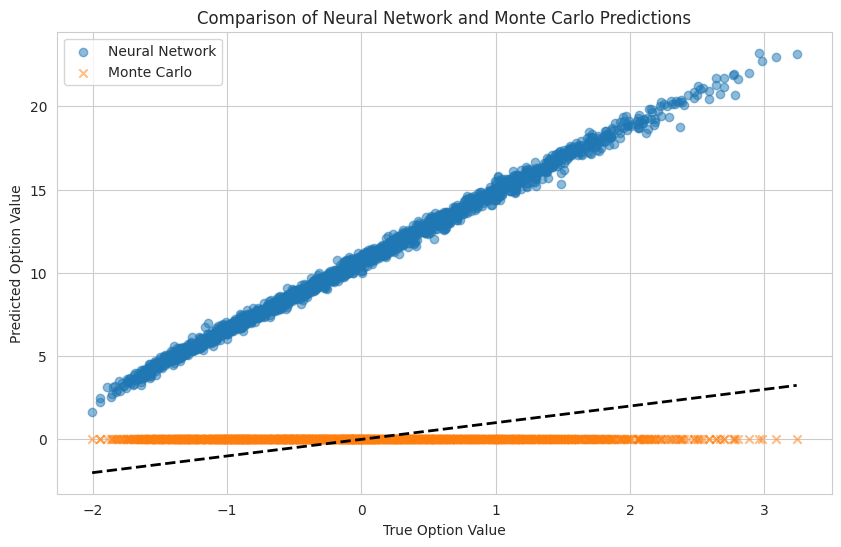

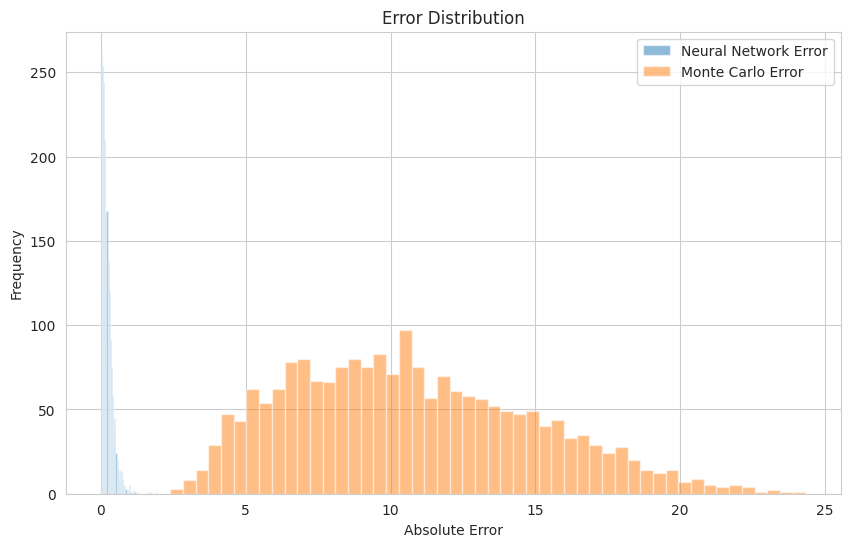

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters for generating option basket data
np.random.seed(42)
n_samples = 10000
n_assets = 5
risk_free_rate = 0.05
volatility = 0.2
time_to_maturity = 1
strike_price = 100

# Simulate data
def generate_option_basket_data(n_samples, n_assets, risk_free_rate, volatility, time_to_maturity, strike_price):
    S = np.random.uniform(80, 120, size=(n_samples, n_assets))  # Asset prices
    weights = np.random.dirichlet(np.ones(n_assets), size=n_samples)  # Basket weights
    basket_price = np.sum(weights * S, axis=1)
    d1 = (np.log(basket_price / strike_price) + (risk_free_rate + 0.5 * volatility**2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    basket_value = basket_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2)
    return S, weights, basket_value

# Generate data
from scipy.stats import norm

S, weights, basket_value = generate_option_basket_data(n_samples, n_assets, risk_free_rate, volatility, time_to_maturity, strike_price)
X = np.hstack([S, weights])  # Features: prices and weights
y = basket_value  # Target: basket option value

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Build and train neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

# Predictions
y_pred_nn = scaler_y.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1)).flatten()

# Monte Carlo estimation
def monte_carlo_pricing(S, weights, strike_price, risk_free_rate, volatility, time_to_maturity, n_paths=10000):
    n_samples, n_assets = S.shape
    basket_values = []
    for i in range(n_samples):
        paths = np.random.normal(size=(n_paths, n_assets))
        asset_prices = S[i, :] * np.exp((risk_free_rate - 0.5 * volatility**2) * time_to_maturity + volatility * np.sqrt(time_to_maturity) * paths)
        basket_prices = np.sum(weights[i, :] * asset_prices, axis=1)
        payoffs = np.maximum(basket_prices - strike_price, 0)
        basket_values.append(np.exp(-risk_free_rate * time_to_maturity) * np.mean(payoffs))
    return np.array(basket_values)

y_pred_mc = monte_carlo_pricing(X_test[:, :n_assets], X_test[:, n_assets:], strike_price, risk_free_rate, volatility, time_to_maturity)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5, label='Neural Network', marker='o')
plt.scatter(y_test, y_pred_mc, alpha=0.5, label='Monte Carlo', marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Option Value')
plt.ylabel('Predicted Option Value')
plt.title('Comparison of Neural Network and Monte Carlo Predictions')
plt.legend()
plt.show()

# Errors
nn_error = np.abs(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() - y_pred_nn)
mc_error = np.abs(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() - y_pred_mc)

plt.figure(figsize=(10, 6))
plt.hist(nn_error, bins=50, alpha=0.5, label='Neural Network Error')
plt.hist(mc_error, bins=50, alpha=0.5, label='Monte Carlo Error')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

